In [1]:
import math
import pandas as pd 
import numpy as np 

import warnings

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

import matplotlib.pyplot as plt 
import seaborn as sns 

warnings.filterwarnings("ignore")

sns.set()

In [2]:
df = pd.read_csv('./ui_timeseries.csv', sep=',')

df.drop(columns=['Unnamed: 0'], inplace=True)

df.head()

,Series,Periode,Permintaan (unit)
0,1,04/07/2008,19210
1,2,04/14/2008,18650
2,3,04/21/2008,14309
3,4,04/28/2008,25226
4,5,05/5/2008,24377


In [3]:
df.tail()

,Series,Periode,Permintaan (unit)
91,92,02/22/2010,13528
92,93,03/1/2010,6480
93,94,03/08/2010,6984
94,95,03/15/2010,9816
95,96,03/22/2010,10738


In [4]:
df.shape

(96, 3)

In [5]:
df.dtypes

Series                int64
Periode              object
Permintaan (unit)     int64
dtype: object

In [6]:
df.duplicated().sum()

0

In [7]:
df['Periode'] = df['Periode'].astype('datetime64[ns]')

df.dtypes

Series                        int64
Periode              datetime64[ns]
Permintaan (unit)             int64
dtype: object

In [8]:
df['Periode'] = pd.to_datetime(df['Periode'])

df.head()

,Series,Periode,Permintaan (unit)
0,1,2008-04-07,19210
1,2,2008-04-14,18650
2,3,2008-04-21,14309
3,4,2008-04-28,25226
4,5,2008-05-05,24377


In [9]:
df = df.set_index('Periode')

df.head()

,Series,Permintaan (unit)
Periode,,
2008-04-07,1,19210
2008-04-14,2,18650
2008-04-21,3,14309
2008-04-28,4,25226
2008-05-05,5,24377


In [10]:
df_origin = df.copy()

df_origin = df_origin[['Permintaan (unit)']]
df_origin = df_origin.rename(columns={'Permintaan (unit)': 'Origin'})

df_origin.head()

,Origin
Periode,
2008-04-07,19210
2008-04-14,18650
2008-04-21,14309
2008-04-28,25226
2008-05-05,24377


In [11]:
adf_test = adfuller(df['Permintaan (unit)'])

In [12]:
def test_stationarity_adf(df):
    adf_test = adfuller(df['Permintaan (unit)'])
    
    adf_df = pd.DataFrame(columns=['Statistic Test', 'p-value', 'No. of lag used', 'No. of observation', 
                               'Critical value (1%)', 'Critical value (5%)', 'Critical value (10%)'], 
                               data=[[adf_test[0], adf_test[1], adf_test[2], adf_test[3], 
                                     adf_test[4]['1%'], adf_test[4]['5%'], adf_test[4]['10%']]])
    
    return adf_df

In [13]:
def plot_timeseries(df):
    plt.figure(figsize=(8,6))

    plt.plot(df['Permintaan (unit)'], color='blue', label="data", alpha=0.7, linewidth=0.8)
    plt.plot(df['Permintaan (unit)'].rolling(7).mean(), color='black', label="mean", linewidth=0.8)
    plt.plot(df['Permintaan (unit)'].rolling(7).std(), color='red', label="standar deviasi", linewidth=0.8)

    plt.xticks(rotation=45)
    plt.title("Data, Mean dan Standar Deviasi Produk PT Indonesia Epson Industry")
    plt.xlabel('Tanggal')
    plt.ylabel('Jumlah Produk')
    plt.tight_layout()

    plt.xticks(rotation=45)
    plt.tight_layout()

    plt.legend(loc='best')

In [14]:
test_stationarity_adf(df)

,Statistic Test,p-value,No. of lag used,No. of observation,Critical value (1%),Critical value (5%),Critical value (10%)
0,-1.180771,0.681812,10,85,-3.509736,-2.896195,-2.585258


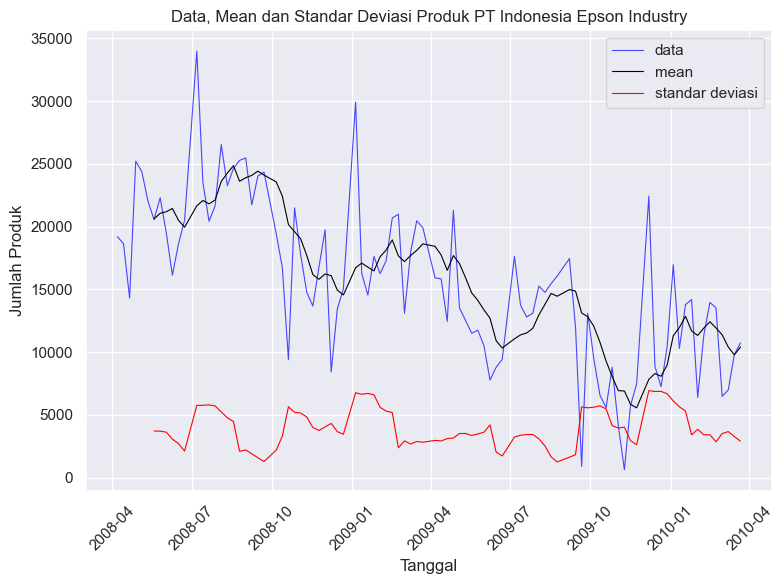

In [15]:
plot_timeseries(df)

In [16]:
df = df.diff(1)

df[df['Permintaan (unit)'].isnull()]

,Series,Permintaan (unit)
Periode,,
2008-04-07,NaN,NaN


In [17]:
df = df.dropna(subset='Permintaan (unit)')

df[df['Permintaan (unit)'].isnull()]

,Series,Permintaan (unit)
Periode,,


In [18]:
df.shape

(95, 2)

In [19]:
df.head()

,Series,Permintaan (unit)
Periode,,
2008-04-14,1.0,-560.0
2008-04-21,1.0,-4341.0
2008-04-28,1.0,10917.0
2008-05-05,1.0,-849.0
2008-05-12,1.0,-2338.0


In [20]:
test_stationarity_adf(df)

,Statistic Test,p-value,No. of lag used,No. of observation,Critical value (1%),Critical value (5%),Critical value (10%)
0,-3.500117,0.007984,9,85,-3.509736,-2.896195,-2.585258


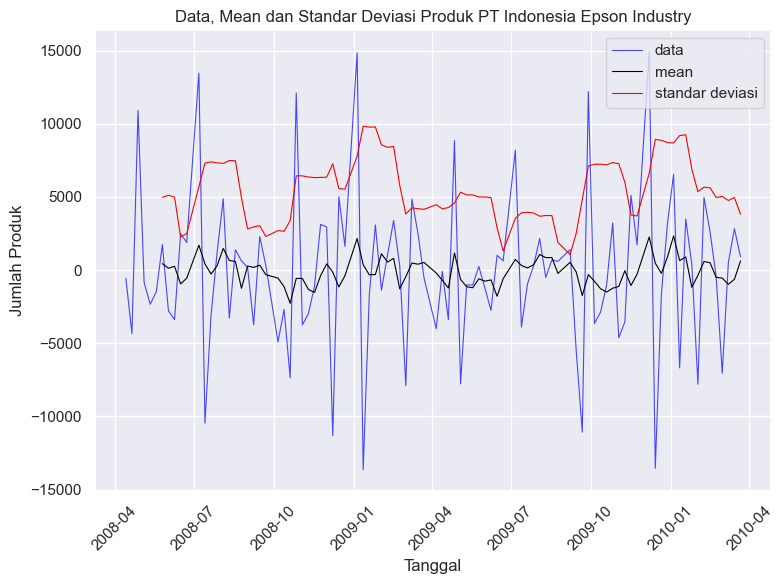

In [21]:
plot_timeseries(df)

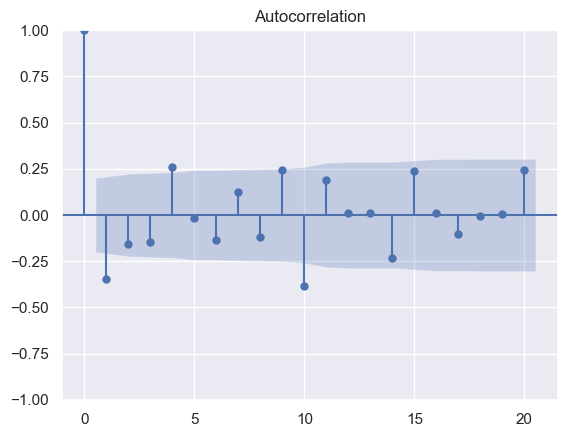

In [22]:
plot = plot_acf(df['Permintaan (unit)']);

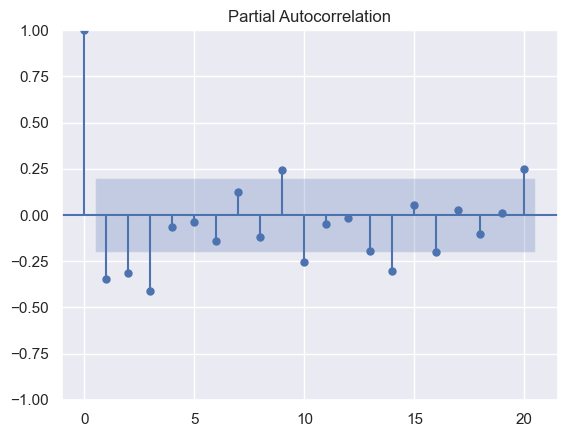

In [23]:
plot_pacf(df['Permintaan (unit)']);

In [24]:
df = df.drop(columns=['Series'])

In [25]:
df.head()

,Permintaan (unit)
Periode,
2008-04-14,-560.0
2008-04-21,-4341.0
2008-04-28,10917.0
2008-05-05,-849.0
2008-05-12,-2338.0


In [26]:
df = pd.concat([df, df_origin], axis=1, join='inner')

# df = df.fillna(0)

df = df.dropna()

df.head()

,Permintaan (unit),Origin
Periode,,
2008-04-14,-560.0,18650
2008-04-21,-4341.0,14309
2008-04-28,10917.0,25226
2008-05-05,-849.0,24377
2008-05-12,-2338.0,22039


In [27]:
def ARIMA_model(df, p, d, q):
    model = ARIMA(endog=df['Permintaan (unit)'], order=(p,d,q))
    model = model.fit()

    pred = model.predict(start='2009-10-05', stop='2010-03-22')
    # pred = model.predict(start='2008-04-14', stop='2010-03-22')
    pred = pred.to_list()

    summary = df.reset_index()

    summary = summary.loc[(summary['Periode'] >= '2009-10-05') & (summary['Periode'] <= '2010-03-22')]	
    summary = summary[['Periode', 'Origin']]

    summary = summary.set_index('Periode')

    summary['Prediksi'] = np.cumsum(pred) + summary['Origin']
    summary['Error'] = summary['Origin'] - summary['Prediksi'] 
    summary['Absolute Error'] = np.abs(summary['Origin'] - summary['Prediksi'])

    return model, summary
        

In [28]:
def model_evaluation(model, summary):
    print('MAE :', mean_absolute_error(summary['Origin'], summary['Prediksi']))
    print('MAPE : %.6f' % (mean_absolute_percentage_error(summary['Origin'], summary['Prediksi'])))
    print('MSE :', mean_squared_error(summary['Origin'], summary['Prediksi']))
    print('RMSE :', np.sqrt(mean_squared_error(summary['Origin'], summary['Prediksi'])))
    print('SSE :', model.sse)

    plt.plot(summary['Origin'], label="Aktual")
    plt.plot(summary['Prediksi'], label="Prediksi", linestyle='dashed', color='red')

    plt.xticks(rotation=45)
    plt.title("Aktual VS Prediksi Produk PT Indonesia Epson Industry")
    plt.xlabel('Tanggal')
    plt.ylabel('Jumlah Produk')
    plt.tight_layout()

    plt.grid(True)

    plt.legend(loc='best')

In [29]:
model_1_1_1, summary_1_1_1 = ARIMA_model(df=df, p=1, d=1, q=1)
model_2_1_1, summary_2_1_1 = ARIMA_model(df=df, p=2, d=1, q=1)
model_3_1_1, summary_3_1_1 = ARIMA_model(df=df, p=3, d=1, q=1)

In [30]:
summary_1_1_1

,Origin,Prediksi,Error,Absolute Error
Periode,,,,
2009-10-05,9456,5094.129973,4361.870027,4361.870027
2009-10-12,6580,3306.316853,3273.683147,3273.683147
2009-10-19,5572,3067.660811,2504.339189,2504.339189
2009-10-26,8800,6400.220634,2399.779366,2399.779366
2009-11-02,4172,464.802059,3707.197941,3707.197941
2009-11-09,632,-1730.650887,2362.650887,2362.650887
2009-11-16,5744,4289.537782,1454.462218,1454.462218
2009-11-23,7470,4008.803572,3461.196428,3461.196428
2009-12-07,22424,18164.788742,4259.211258,4259.211258


In [31]:
summary_2_1_1

,Origin,Prediksi,Error,Absolute Error
Periode,,,,
2009-10-05,9456,7084.193511,2371.806489,2371.806489
2009-10-12,6580,1886.661466,4693.338534,4693.338534
2009-10-19,5572,2998.252017,2573.747983,2573.747983
2009-10-26,8800,7225.535184,1574.464816,1574.464816
2009-11-02,4172,1165.718500,3006.281500,3006.281500
2009-11-09,632,-1611.733925,2243.733925,2243.733925
2009-11-16,5744,6085.918381,-341.918381,341.918381
2009-11-23,7470,6224.702400,1245.297600,1245.297600
2009-12-07,22424,18542.686464,3881.313536,3881.313536


In [32]:
summary_3_1_1

,Origin,Prediksi,Error,Absolute Error
Periode,,,,
2009-10-05,9456,9609.685594,-153.685594,153.685594
2009-10-12,6580,6885.664744,-305.664744,305.664744
2009-10-19,5572,4021.999930,1550.000070,1550.000070
2009-10-26,8800,10223.457734,-1423.457734,1423.457734
2009-11-02,4172,4906.438216,-734.438216,734.438216
2009-11-09,632,2352.032675,-1720.032675,1720.032675
2009-11-16,5744,9872.825619,-4128.825619,4128.825619
2009-11-23,7470,11625.936314,-4155.936314,4155.936314
2009-12-07,22424,23966.330764,-1542.330764,1542.330764


In [33]:
model_1_1_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      Permintaan (unit)   No. Observations:                   95
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -938.835
Date:                Sat, 07 Oct 2023   AIC                           1883.670
Time:                        17:22:58   BIC                           1891.300
Sample:                             0   HQIC                          1886.752
                                 - 95                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3431      0.086     -3.972      0.000      -0.512      -0.174
ma.L1         -1.0000      0.120     -8.346      0.000      -1.235      -0.765
sigma2      2.651e+07   4.52e-09   5.87e+15      0.000    2.65e+07    2.65e+07
===================================================================================
Ljung-Box (L1) (Q):                   1.16   Jarque-Bera (JB):                 8.58
Prob(Q):                              0.28   Prob(JB):                         0.01
Heteroskedasticity (H):               1.29   Skew:                             0.54
Prob(H) (two-sided):                  0.48   Kurtosis:                         4.01
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.98e+30. Standard errors may be unstable.
"""

In [34]:
model_3_1_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      Permintaan (unit)   No. Observations:                   95
Model:                 ARIMA(3, 1, 1)   Log Likelihood                -930.607
Date:                Sat, 07 Oct 2023   AIC                           1871.215
Time:                        17:22:58   BIC                           1883.931
Sample:                             0   HQIC                          1876.351
                                 - 95                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5794      0.205     -2.825      0.005      -0.981      -0.177
ar.L2         -0.4861      0.219     -2.218      0.027      -0.916      -0.057
ar.L3         -0.3954      0.184     -2.155      0.031      -0.755      -0.036
ma.L1         -0.9827      0.129     -7.594      0.000      -1.236      -0.729
sigma2      3.237e+07   3.52e-09   9.19e+15      0.000    3.24e+07    3.24e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.10   Jarque-Bera (JB):                67.87
Prob(Q):                              0.75   Prob(JB):                         0.00
Heteroskedasticity (H):               1.28   Skew:                             0.91
Prob(H) (two-sided):                  0.50   Kurtosis:                         6.74
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.27e+31. Standard errors may be unstable.
"""

MAE : 5232.205801127591
MAPE : 0.717559
MSE : 31580264.31056878
RMSE : 5619.632044054912
SSE : 2614298141.1990933


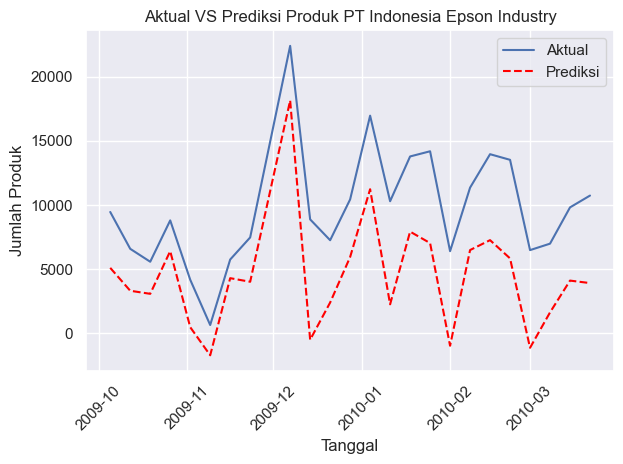

In [35]:
model_evaluation(model=model_1_1_1, summary=summary_1_1_1)

MAE : 6240.581458339297
MAPE : 0.818295
MSE : 50367441.677959345
RMSE : 7097.002302237146
SSE : 2377048646.1276083


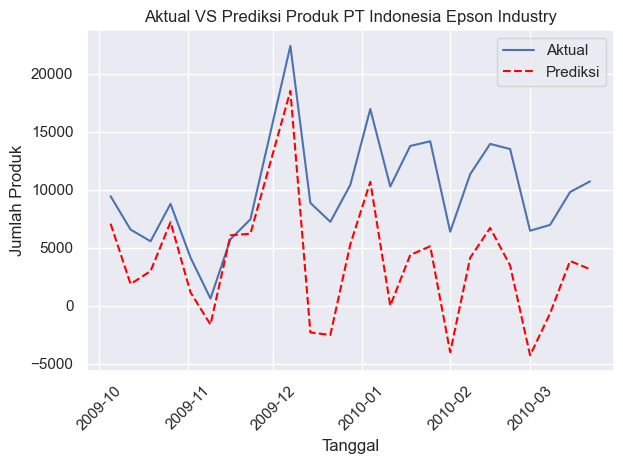

In [36]:
model_evaluation(model=model_2_1_1, summary=summary_2_1_1)

MAE : 6432.603992602725
MAPE : 0.805270
MSE : 58140061.470707715
RMSE : 7624.96304716998
SSE : 2022834627.2498305


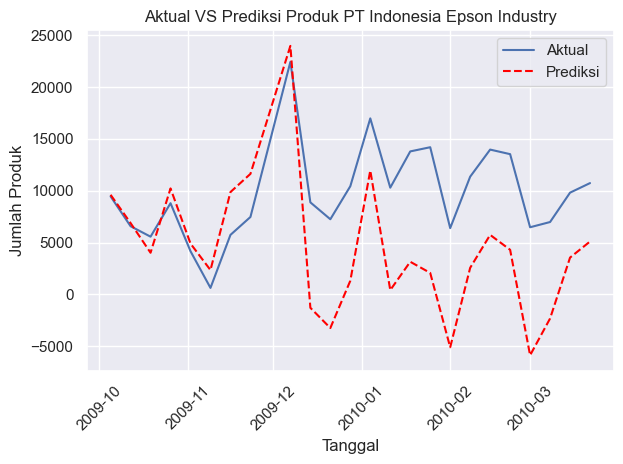

In [37]:
model_evaluation(model=model_3_1_1, summary=summary_3_1_1)